In [ ]:
%matplotlib inline
! pip install wget
! pip install seaborn
! pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



# NLP From Scratch
When dealing with sequence data, there exists several possible pipelines. The sequence indeed, might be the output of the classification problem, the input, or both. Recurrent Neural Networks (RNNs) have been historically the neural architecture used to deal with sequence data. 

To further analyse the reason behind their effectivness and deeply understand their working principles I suggest you to read the folloiwng articels: 
-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   is about LSTMs specifically but also informative about RNNs in
   general




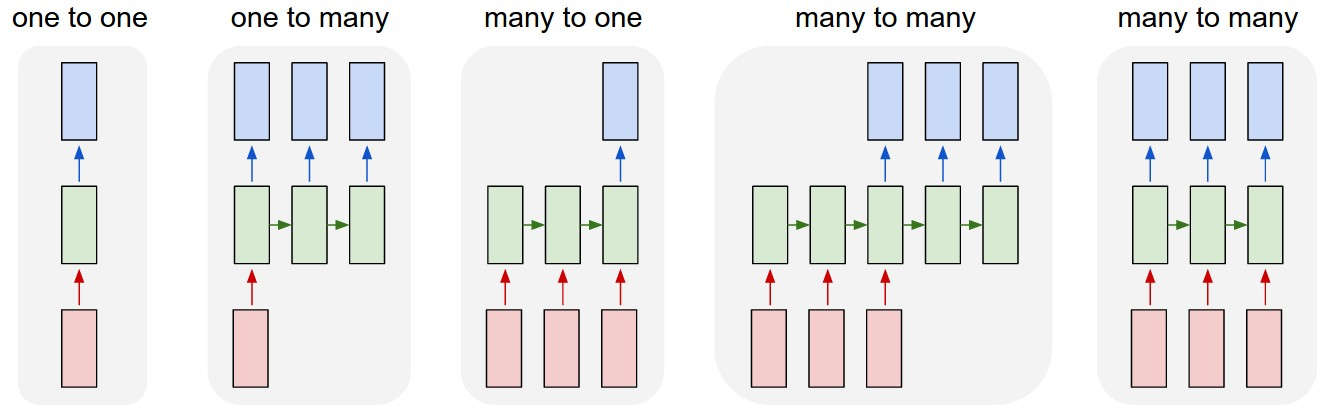

## Many-to-one Classification: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify
words. This tutorial show how to do
preprocess data for NLP modeling "from scratch", so you can see how
preprocessing for NLP modeling works at a low level. For more complex pipelines and datasets, I suggest you to employ the [TorchText](https://pytorch.org/text/stable/index.html) library (which, however, it's a little bit tricky so we won't use it in this course).

A character-level RNN reads words as a series of characters -
outputting a prediction and feeding its
previous hidden state into each next step. We take the final prediction, $f(x) = \sigma(h_t)$, to be the output prediction of which language the word belongs to. 



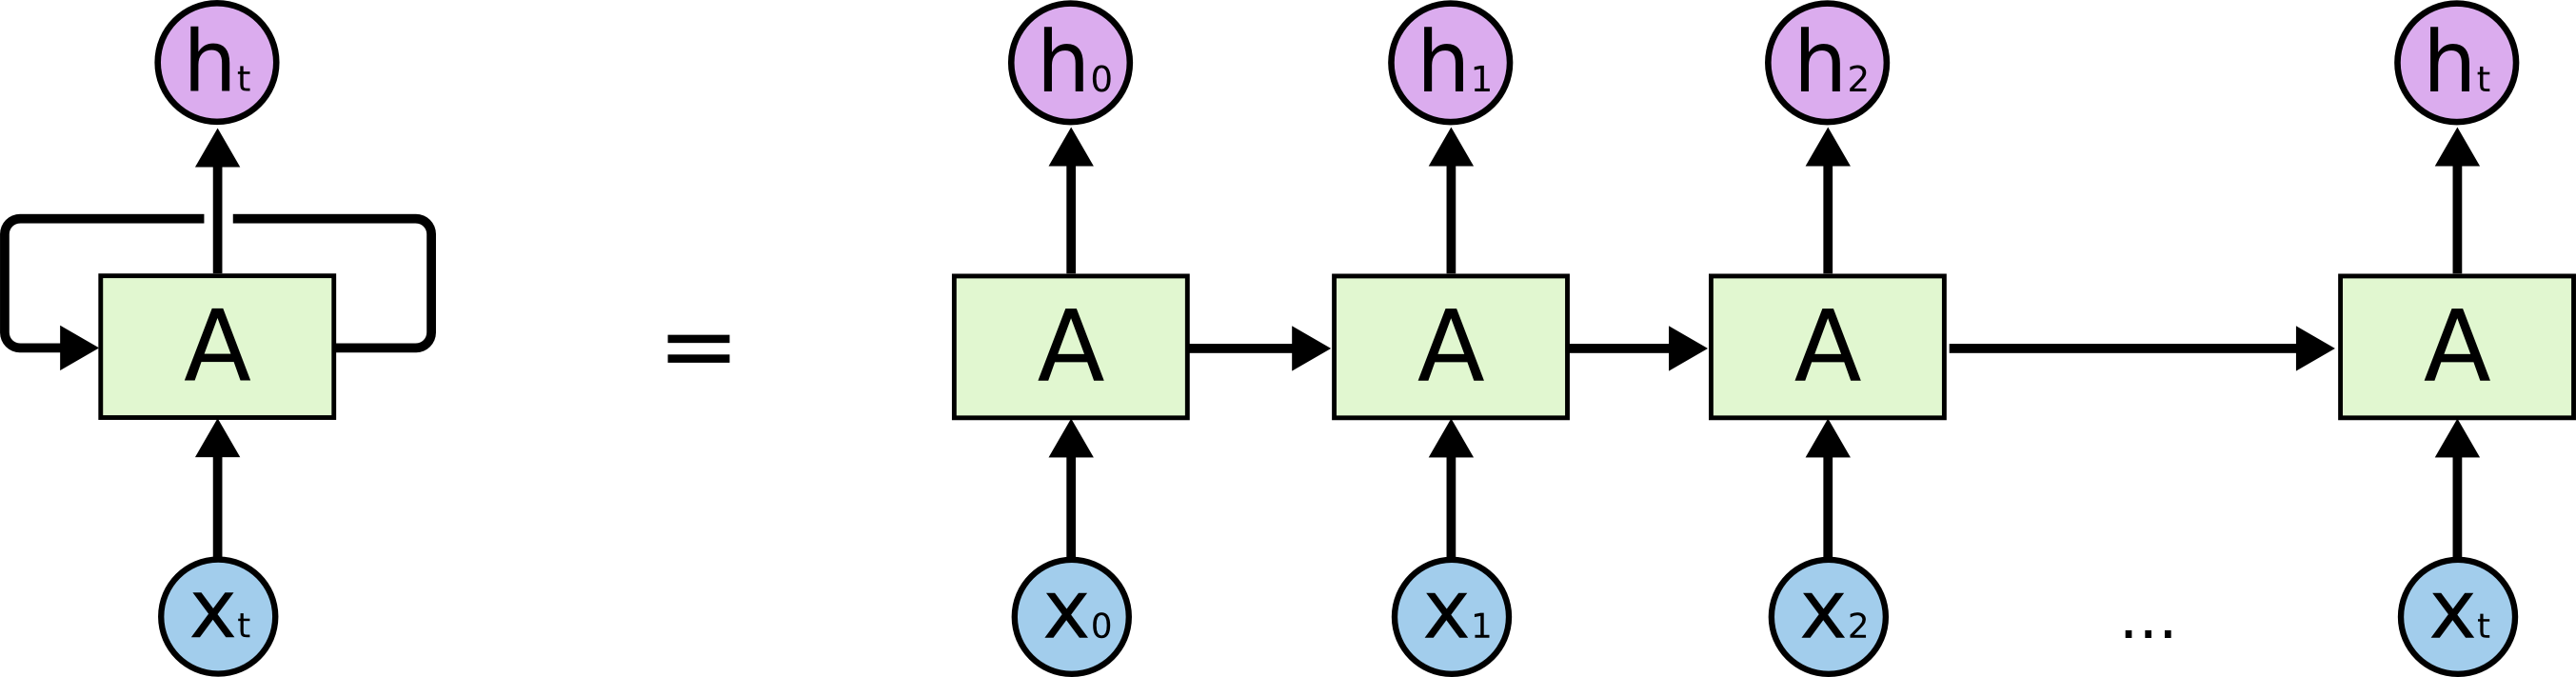


Specifically, we'll train an RNN to perform Name-language Classification. We will use a dataset composed of a few thousand surnames from 18 different languages. The network will predict from which language a name is based on the
spelling:


    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

## Preparing the Data

We will download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

Included in the ``data/names`` directory there will be 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
from torch.utils.data import Dataset


class NamesDataset(Dataset):
    def __init__(self, root="."):
        super().__init__()

        # initialize letter dictionary
        self.all_letters = string.ascii_letters
        self.n_letters = len(self.all_letters)

        # download dataset
        self._download_dataset(root)
        self.root = os.path.join(root, "data", "names")

        # Build the category_lines dictionary, a list of names per language
        self.lines = []
        self.labels = []
        self.classes = []
        for i, filename in enumerate(os.listdir(self.root)):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.classes.append(category)
            lines = self._readLines(filename)
            self.lines.extend(lines)
            self.labels.extend([i] * len(lines))

        self.n_classes = len(self.classes)


    # Couple of utils functions
    # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
    def _unicodeToAscii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.all_letters
        )

    # Read lines from a file and and convert them to ASCII
    def _readLines(self, filename):
        path = os.path.join(self.root, filename)
        lines = open(path, encoding='utf-8').read().strip().split('\n')
        return [self._unicodeToAscii(line) for line in lines]

    # Private function to download the dataset
    def _download_dataset(self, root):
        import shutil
        import wget
        import zipfile
        if os.path.exists(root) and root != ".":
            shutil.rmtree(root) # make sure there is nothing in our folder

        if root != ".":
            os.makedirs(root) # create folders
        wget.download("https://download.pytorch.org/tutorial/data.zip", 
                      root) # download dataset
        with zipfile.ZipFile(os.path.join(root, "data.zip"), 'r') as zip_ref:
            zip_ref.extractall(".") # extract dataset


        
ds = NamesDataset(".")

print(ds._unicodeToAscii('Ślusàrski'))



Slusarski


Now we have a dataset, with the complete list of names in ``ds.data`` and the corresponding list of language index ``ds.labels``. 

We also kept track of ``ds.classes`` (just a list of languages) and ``ds.n_classes`` (number of classes).
<!-- and ``ds.max_lenght`` (max word length) for later reference. -->



In [2]:
print(ds.lines[:5])
print(ds.labels[:5])
print(f"Number of classes: {ds.n_classes}, Classes: {ds.classes}")

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
[0, 0, 0, 0, 0]
Number of classes: 18, Classes: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we will use a "one-hot vector" of size
``<n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
To make a word we join a bunch of those into a 3D matrix
``<line_length x n_letters>``.

For words the one-hot econding representation is also called *Bag of Words*. However, to have richer semantic representation of the words, several encoding algorithms have been developed, the most famous of which is *Word2Vec*. 


In [3]:
import torch

class NamesDataset(NamesDataset):

    # Find letter index from all_letters, e.g. "a" = 0
    def letter_2_index(self, letter):
        return self.all_letters.find(letter)

    # Turn a line into a <line_length  x n_letters>,
    # or an array of one-hot letter vectors
    def word_2_tensor(self, line):
        tensor = torch.zeros(len(line), self.n_letters)
        for i, letter in enumerate(line):
            tensor[i][self.letter_2_index(letter)] = 1
        return tensor
         
ds = NamesDataset()
print("Representation of the words 'Jones'")
print(ds.word_2_tensor('Jones'))

Representation of the words 'Jones'
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

We will employ a very simple RNN model with just 2 linear layers which operate on an input and hidden state, and a LogSoftmax layer after the output. The recursion is provided by the only hidden state which is held in memory.

![](https://i.imgur.com/Z2xbySO.png)

<!-- .. figure:: https://i.imgur.com/Z2xbySO.png
   :alt: -->
More specifically, in yellow are displayed tensors, in blue are displayed linear weight layers and in light blue the activation function.




In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.init_hidden()

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input):
        combined = torch.cat((input, self.hidden), 1)
        hidden = self.i2h(combined)
        
        self.hidden = hidden # store value in memory for next forward!
        
        output = self.i2o(combined)
        output = self.softmax(output)
        return output

    def init_hidden(self): # to reset hidden state
        self.hidden = torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(ds.n_letters, n_hidden, ds.n_classes)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter). At first the hidden state will be
initialized as zeros. We'll get back the output (probability of
each language). The network will store the hidden state for the next
step.




In [5]:
input = ds.word_2_tensor('Angel').unsqueeze(dim=0)

output = rnn(input[:, 0]) # 0 to select the first letter of the word
output

tensor([[-2.9362, -2.8953, -2.9388, -2.8924, -2.9847, -2.8935, -2.8366, -2.8889,
         -2.8160, -2.9219, -3.0008, -2.9062, -2.8315, -2.7556, -2.8586, -2.9093,
         -2.9943, -2.8045]], grad_fn=<LogSoftmaxBackward0>)

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

You may think that this output is meaningless beacuse the network is not trained yet. However, even after training, reading the output of the network after the first letter does not make sense! We *always* need to finish processing the entire word.




## Training
----------------------
We will also want a quick way to get a training example (a name and its
language). To do so we will further extend our ``NamesDataset`` class to have a ``__get_item__`` and a ``__len__`` function that we will use to index the dataset and get the # samples. 

Together with a ``DataLoader``, they will allows us to loop over the dataset. 




In [ ]:
from abc import abstractclassmethod
import random

class NamesDataset(NamesDataset):
    
    def __getitem__(self, index):
        line = self.lines[index]
        x = self.word_2_tensor(line)
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.labels)
    
    def tensor_2_word(self, x):
        word = []
        for x_i in x:
            idx = x_i.argmax()
            letter = ds.all_letters[idx]
            word.append(letter)
        return ''.join(word)
        

ds = NamesDataset()
for i in range(10):
    x, y = ds[i]
    print('category =', ds.classes[i], '/ name =', ds.tensor_2_word(x))
print(f"Number of samples: {len(ds)}")

category = Scottish / name = Smith
category = Dutch / name = Brown
category = German / name = Wilson
category = Arabic / name = Campbell
category = Polish / name = Stewart
category = Italian / name = Thomson
category = Greek / name = Robertson
category = Spanish / name = Anderson
category = French / name = Macdonald
category = Japanese / name = Scott
Number of samples: 20074


### Training the Network

We forget to create the training and test data. Let's use the ``random_split`` function from pytorch this time. It will create two ``Subset`` of our datasets with the required amount of training and test samples.

For the loss function ``nn.NLLLoss`` is still appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.

Notice: we're just using a **batch_size = 1** here. This is beacause all words have different length and therefore we cannot directly perform batch prediction. It would require padding the input to a same dimensions and masking the output to get the correct final prediction: for the sake of simplicity we avoid doing it here. 




In [ ]:
from torch.utils.data import DataLoader, random_split

epochs = 5
batch_size = 1
learning_rate = 0.01

train_samples, test_samples = int(0.9*len(ds)), len(ds)-int(0.9*len(ds))
train_ds, test_ds = random_split(ds, (train_samples, test_samples))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

rnn = RNN(ds.n_letters, n_hidden, ds.n_classes)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters())

print(f"# Train samples {train_samples}, # Test samples {test_samples}")


# Train samples 18066, # Test samples 2008


### Training step:
In this training step we have to:

-  Read each letter in the input $x$
    - **watch out**: $x$ will be now ``<# samples, # letters, input size>``
    - to loop on the letter you have to index the 2nd dimension
    - batch size = 1, so we only one deal with one sample at a time 
-  Compare final output to target
-  Back-propagate
-  Re-initialize the hidden state 
-  Return the output and loss



In [ ]:
def train_step(rnn, x, y, criterion, optim):
    # FILL IT YOURSELF!

    return output, loss.item()

## Evaluation step
In this evaluation step we only have to the same things as above but without backpropagating.

In [ ]:
def eval_step(rnn, x, y, criterion):
    # FILL IT YOURSELF!


    return output, loss.item()

Since the ``train`` function returns both the output and loss we can print its
guesses and also keep track of loss and accuracy for plotting. 

We don't use gpu this time since we are not performing batch computation and input and net dimension are very small. The complete training should take about 5 min. 

In [ ]:
import time
import math

# Keep track of losses and accs
df = {
    "epoch": [],
    "loss": [],
    "acc": [],
    "mode": [],
}

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for e in range(epochs):
    train_loss, train_acc = 0, 0.
    for x, y in train_dl:
        output, loss = train_step(rnn, x, y, criterion, optimizer)
        train_loss += loss
        train_acc += output.argmax() == y

    # Store train avg epoch loss and accuracy  
    df["loss"].append(train_loss / train_samples)
    df["acc"].append(train_acc.item() / train_samples)
    df["mode"].append("train"), df["epoch"].append(e)

    test_loss, test_acc = 0, 0.
    for x, y in test_dl:
        output, loss = eval_step(rnn, x, y, criterion)
        test_loss += loss
        test_acc += output.argmax() == y

    # Store test avg epoch loss and accuracy  
    df["loss"].append(test_loss / test_samples)
    df["acc"].append(test_acc.item() / test_samples)
    df["mode"].append("test"), df["epoch"].append(e)
    
    # Print epoch number, loss, name and guess
    class_predict = ds.classes[output.argmax()]
    print('%d/ %d (%s) %.2f %.2f %.2f %.2f' % (e + 1, epochs, timeSince(start),
                                                train_loss / train_samples, 
                                                train_acc / train_samples,
                                                test_loss / test_samples, 
                                                test_acc / test_samples))

### Plotting the Results

Plotting the historical loss and accuracy from ``df`` to shows the network
learning both at train and at test time




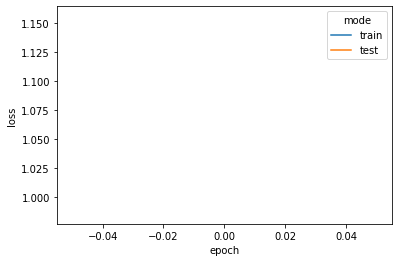

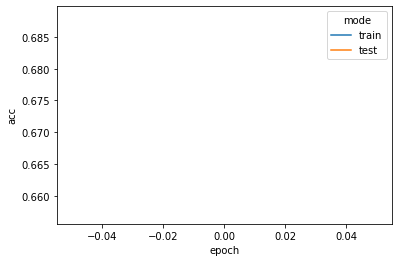

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
df_pd = pd.DataFrame(df)
sns.lineplot(data=df_pd, x="epoch", y='loss', hue="mode")
plt.show()
sns.lineplot(data=df_pd, x="epoch", y='acc', hue="mode")
plt.show()


### Running on User Input




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        # FILL IT YOURSELF!

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, ds.classes[category_index]))
            predictions.append([value, ds.classes[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
tensor([[0., 0., 0., 0., 0., 0., 0.]])


RuntimeError: ignored

## Exercises

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

You can find many easy-to-use datasets in [scikit-learn](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html). 


